##0 - Load the Data and Visualize it!

### Link Google Colab to Google Drive

### Import the necessary libraries

In [137]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import open3d as o3d

### Load the Files

In [138]:
image_files = sorted(glob.glob("data/img/*.png"))
point_files = sorted(glob.glob("data/velodyne/*.pcd"))
label_files = sorted(glob.glob("data/label/*.txt"))
calib_files = sorted(glob.glob("data/calib/*.txt"))

index = 0
pcd_file = point_files[index]
image = cv2.cvtColor(cv2.imread(image_files[index]), cv2.COLOR_BGR2RGB)
cloud = o3d.io.read_point_cloud(pcd_file)
points= np.asarray(cloud.points)

### Optional - If your LiDAR file is in binary extension '.bin', use this piece of code to turn it into a '.pcd' and save it

### Visualize the Image

Text(0.5, 1.0, 'Image')

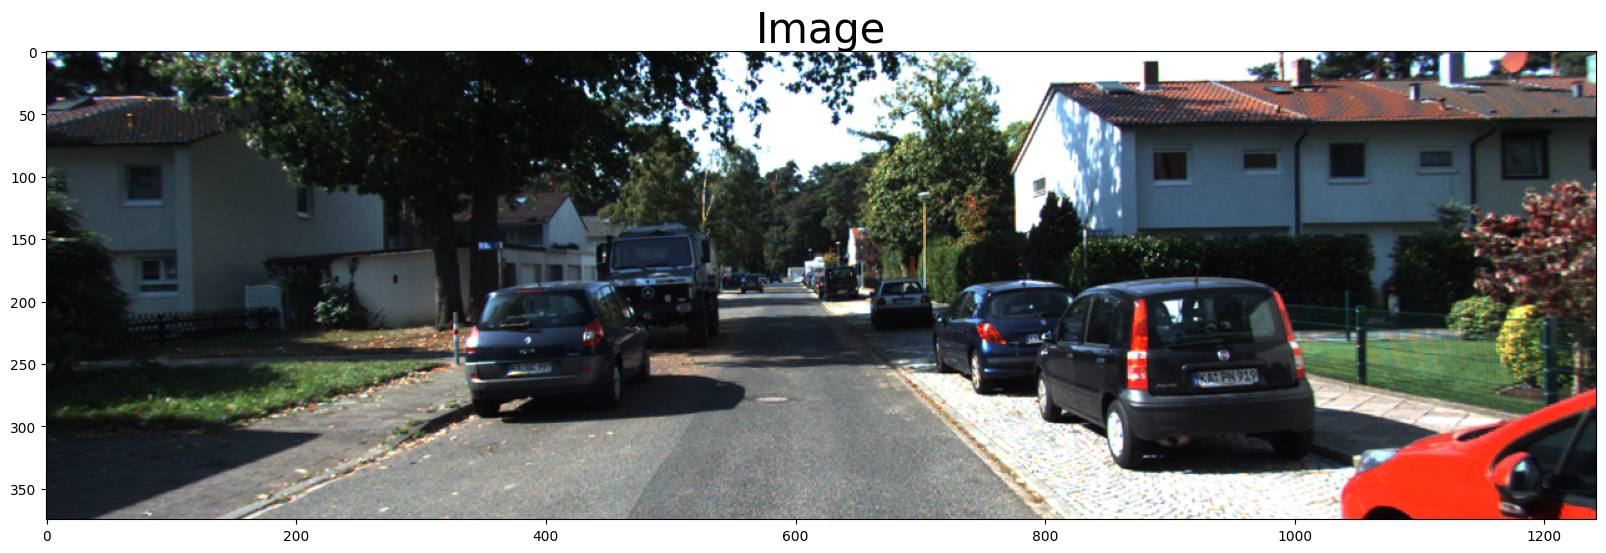

In [139]:
f, (ax1) = plt.subplots(1, 1, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Image', fontsize=30)

### Visualize the Point Clouds

## 1 - Project the Points in the Image <p>
That part is possibly the hardest to understand and will require your full attention. We want to project the 3D points into the image.<p>

It means we'll need to: <p>

*   Select the Point that are **visible** in the image 🤔
*   Convert the Points **from the LiDAR frame to the Camera Frame** 🤯
*   Find a way to project **from the Camera Frame to the Image Frame** 😭

<p>
No worries here, we'll figure out everything together.


### 1.1 - Read the Calibration File

The first step is to read the calibration files. For each image, we have an associated calibration file that states:<p>


*   The instrinsic and extrinsic camera calibration parameters
*   The velodyne to camera matrices
*   All the other "sensor A" to "sensor B" matrices
<p>
They are made from this setup:<p>

![link text](http://www.cvlibs.net/datasets/kitti/images/setup_top_view.png)

Not everything matters to us here, only a few things:
*    **Velo-To-Cam is a variable we'll call V2C** -- It gives the rotation and translation matrices from the Velodyne to the Left Grayscale camera.
*    **R0_rect used in Stereo Vision to make the images co-planar.**
*   **P2 is the matrix obtained after camera calibration**. It contains the intrinsic matrix K and the extrinsic.


In [140]:
class LiDAR2Camera(object):
    def __init__(self, calib_file):
        calibs = self.read_calib_file(calib_file)
        P = calibs["P2"]
        self.P = np.reshape(P, [3, 4])
        # Rigid transform from Velodyne coord to reference camera coord
        V2C = calibs["Tr_velo_to_cam"]
        self.V2C = np.reshape(V2C, [3, 4])
        # Rotation from reference camera coord to rect camera coord
        R0 = calibs["R0_rect"]
        self.R0 = np.reshape(R0, [3, 3])

    def read_calib_file(self, filepath):
        """ Read in a calibration file and parse into a dictionary.
        Ref: https://github.com/utiasSTARS/pykitti/blob/master/pykitti/utils.py
        """
        data = {}
        with open(filepath, "r") as f:
            for line in f.readlines():
                line = line.rstrip()
                if len(line) == 0:
                    continue
                key, value = line.split(":", 1)
                # The only non-float values in these files are dates, which
                # we don't care about anyway
                try:
                    data[key] = np.array([float(x) for x in value.split()])
                except ValueError:
                    pass
        return data

In [141]:
lidar2cam = LiDAR2Camera(calib_files[index])
print("P :"+str(lidar2cam.P))
print("-")
print("RO "+str(lidar2cam.R0))
print("-")
print("Velo 2 Cam " +str(lidar2cam.V2C))
print("-")
#print("Cam 2 Velo" + str(lidar2cam.C2V))

P :[[     721.54           0      609.56      44.857]
 [          0      721.54      172.85     0.21638]
 [          0           0           1   0.0027459]]
-
RO [[    0.99992   0.0098378   -0.007445]
 [ -0.0098698     0.99994  -0.0042785]
 [  0.0074025   0.0043516     0.99996]]
-
Velo 2 Cam [[  0.0075337    -0.99997  -0.0006166  -0.0040698]
 [   0.014802  0.00072807    -0.99989   -0.076316]
 [    0.99986   0.0075238    0.014808    -0.27178]]
-


### 1.2 - Project the Points in the Image

The main formula we'll use will be as follows:<p>
**Y(2D) = P x R0 x R|t x X (3D)** 

However, when looking at the dimensions:

*   P: [3x4]
*   R0: [3x3]
*   R|t = Velo2Cam: [3x4]
*   X: [3x1]

We'll need to convert some points into Homogeneous Coordinates:
* RO must go from 3x3 to 4x3
* x must go from 3x1 to 4x1

Then, to retrieve the cartesian system, we'll divide as explained in the course.

In [142]:
def cart2hom(self, pts_3d):
    """ Input: nx3 points in Cartesian
        Oupput: nx4 points in Homogeneous by pending 1
    """
    n = pts_3d.shape[0]
    pts_3d_hom = np.hstack((pts_3d, np.ones((n, 1))))
    return pts_3d_hom

LiDAR2Camera.cart2hom = cart2hom

In [143]:
def project_velo_to_ref(self, pts_3d_velo):
    pts_3d_velo = self.cart2hom(pts_3d_velo)  # nx4
    return np.dot(pts_3d_velo, np.transpose(self.V2C))

LiDAR2Camera.project_velo_to_ref = project_velo_to_ref

print(points[:1,:])
print(lidar2cam.project_velo_to_ref(points[:1,:]))


[[     21.751       2.534        0.95]]
[[    -2.3747     -0.7024      21.509]]


--- TODO ---
Code the Project_velo_to_image function and test it for the first 5 points. Make sure it makes sense.

In [144]:
def project_velo_to_image(self, pts_3d_velo):
    '''
    Input: 3D points in Velodyne Frame [nx3]
    Output: 2D Pixels in Image Frame [nx2]
    '''
    # REVERSE TECHNIQUE
    '''
    homogeneous = self.cart2hom(pts_3d_velo)  # nx4
    dotted_RT = np.dot(homogeneous, np.transpose(self.V2C)) #nx3
    dotted_with_RO = np.transpose(np.dot(self.R0, np.transpose(dotted_RT))) #nx3
    homogeneous_2 = self.cart2hom(dotted_with_RO) #nx4
    pts_2d = np.dot(homogeneous_2, np.transpose(self.P))  # nx3
    '''
    
    # NORMAL TECHNIQUE
    R0_homo = np.vstack([self.R0, [0, 0, 0]])
    R0_homo_2 = np.column_stack([R0_homo, [0, 0, 0, 1]])
    p_r0 = np.dot(self.P, R0_homo_2) #PxR0
    p_r0_rt =  np.dot(p_r0, np.vstack((self.V2C, [0, 0, 0, 1]))) #PxROxRT
    pts_3d_homo = np.column_stack([pts_3d_velo, np.ones((pts_3d_velo.shape[0],1))])
    p_r0_rt_x = np.dot(p_r0_rt, np.transpose(pts_3d_homo))#PxROxRTxX
    pts_2d = np.transpose(p_r0_rt_x)
    
    pts_2d[:, 0] /= pts_2d[:, 2]
    pts_2d[:, 1] /= pts_2d[:, 2]
    return pts_2d[:, 0:2]


LiDAR2Camera.project_velo_to_image = project_velo_to_image
print(points[:5,:3])
print("Euclidean Pixels "+str(lidar2cam.project_velo_to_image(points[:5,:3])))


[[     21.751       2.534        0.95]
 [     21.762       2.605        0.95]
 [     21.766       2.675       0.951]
 [     21.738       2.706        0.95]
 [     21.761       2.778       0.951]]
Euclidean Pixels [[     526.24      146.96]
 [      523.9         147]
 [     521.56         147]
 [     520.41         147]
 [     518.09      147.03]]


### 1.4 - LiDAR in Image Field Of View

In [145]:
def get_lidar_in_image_fov(self,pc_velo, xmin, ymin, xmax, ymax, return_more=False, clip_distance=2.0):
    """ Filter lidar points, keep those in image FOV """
    pts_2d = self.project_velo_to_image(pc_velo)
    fov_inds = (
        (pts_2d[:, 0] < xmax)
        & (pts_2d[:, 0] >= xmin)
        & (pts_2d[:, 1] < ymax)
        & (pts_2d[:, 1] >= ymin)
    )
    fov_inds = fov_inds & (pc_velo[:, 0] > clip_distance) # We don't want things that are closer to the clip distance (2m)
    imgfov_pc_velo = pc_velo[fov_inds, :]
    if return_more:
        return imgfov_pc_velo, pts_2d, fov_inds
    else:
        return imgfov_pc_velo
    
LiDAR2Camera.get_lidar_in_image_fov = get_lidar_in_image_fov

###1.5 -- Get the LiDAR Points in Pixels

In [146]:
def show_lidar_on_image(self, pc_velo, img, debug="False"):
    """ Project LiDAR points to image """
    imgfov_pc_velo, pts_2d, fov_inds = self.get_lidar_in_image_fov(
        pc_velo, 0, 0, img.shape[1], img.shape[0], True
    )
    if (debug==True):
        print("3D PC Velo "+ str(imgfov_pc_velo)) # The 3D point Cloud Coordinates
        print("2D PIXEL: " + str(pts_2d)) # The 2D Pixels
        print("FOV : "+str(fov_inds)) # Whether the Pixel is in the image or not
    self.imgfov_pts_2d = pts_2d[fov_inds, :]
    '''
    #homogeneous = np.hstack((imgfov_pc_velo, np.ones((imgfov_pc_velo.shape[0], 1))))
    homogeneous = self.cart2hom(imgfov_pc_velo)
    transposed_RT = np.dot(homogeneous, np.transpose(self.V2C))
    dotted_RO = np.transpose(np.dot(self.R0, np.transpose(transposed_RT)))
    self.imgfov_pc_rect = dotted_RO
    
    if debug==True:
        print("FOV PC Rect "+ str(self.imgfov_pc_rect))
    '''
    cmap = plt.cm.get_cmap("hsv", 256)
    cmap = np.array([cmap(i) for i in range(256)])[:, :3] * 255
    self.imgfov_pc_velo = imgfov_pc_velo
    
    for i in range(self.imgfov_pts_2d.shape[0]):
        #depth = self.imgfov_pc_rect[i,2]
        #print(depth)
        depth = imgfov_pc_velo[i,0]
        #print(depth)
        color = cmap[int(510.0 / depth), :]
        cv2.circle(
            img,(int(np.round(self.imgfov_pts_2d[i, 0])), int(np.round(self.imgfov_pts_2d[i, 1]))),2,
            color=tuple(color),
            thickness=-1,
        )

    return img

LiDAR2Camera.show_lidar_on_image = show_lidar_on_image

C:\Users\kagad\AppData\Local\Temp\ipykernel_21572\420554473.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("hsv", 256)


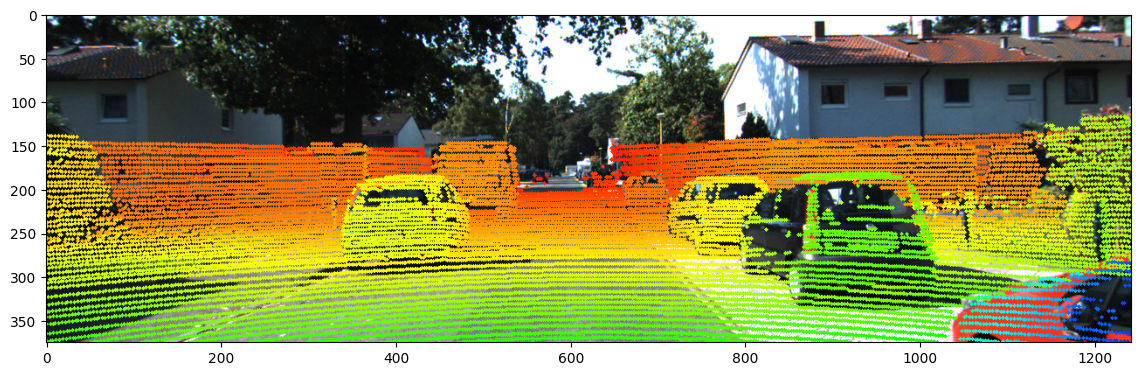

In [147]:
#img_3 = lidar2cam.show_lidar_on_image(points[:,:3], image)
img_3 = image.copy()
img_3 = lidar2cam.show_lidar_on_image(points[:,:3], img_3)
plt.figure(figsize=(14,7))
plt.imshow(img_3)
plt.show()

## 2 - Detect Obstacles in 2D


0: 224x640 5 cars, 1 truck, 57.8ms
Speed: 7.5ms preprocess, 57.8ms inference, 11.8ms postprocess per image at shape (1, 3, 224, 640)


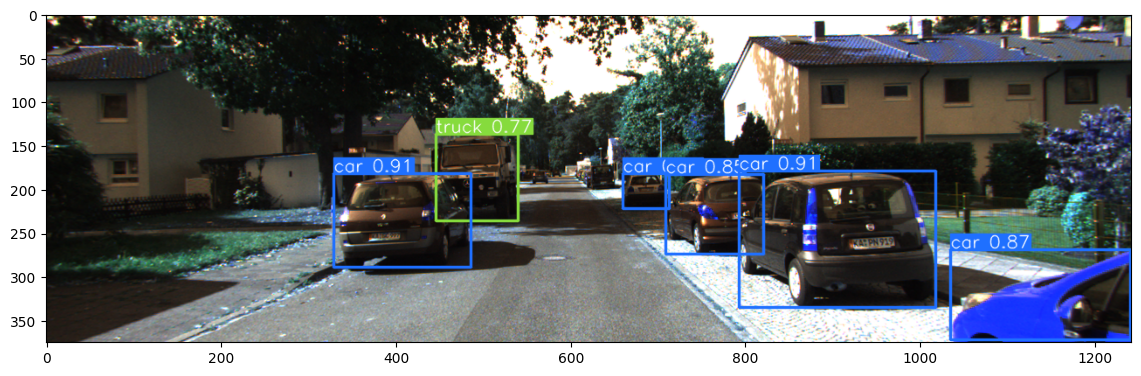

In [148]:
from ultralytics import YOLO
import time
model = YOLO('yolov8s.pt')
def run_obstacle_detection(img):
    start_time=time.time()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    predictions = model(img ,conf = 0.5,classes = [1,2,7])
    for r in predictions:
        pred_bboxes = (r.boxes.data).detach().cpu().numpy()
        result = r.plot()
    return result,pred_bboxes
result, pred_bboxes = run_obstacle_detection(image)

fig_camera = plt.figure(figsize=(14, 7))
ax_lidar = fig_camera.subplots()
ax_lidar.imshow(result)
plt.show()

In [149]:
import cv2
import numpy as np
from PIL import Image

def draw_boxes_cv(img, detections):
    # Open the image only if it's a path
    if isinstance(img, str):
        img = cv2.imread(img)
    # Convert PIL Image to numpy array if necessary
    elif isinstance(img, Image.Image):
        img = np.array(img)
    
    # Assuming class 2 is 'car'
    class_labels = {2: 'car'}
    
    # Loop through detections and draw each as a rectangle
    for detection in detections:
        x1, y1, x2, y2, confidence, class_id = detection
        # Draw rectangle
        cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        
        # Prepare text for class label and confidence
        label = f"{class_labels.get(class_id, str(class_id))}: {confidence:.2f}"
        # Calculate text width & height to draw the transparent boxes as background
        (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)
        
        # Draw background rectangle for text
        cv2.rectangle(img, (int(x1), int(y1) - 20), (int(x1) + w, int(y1) - 20 + h), (0, 255, 0), -1)
        # Put text above rectangle
        cv2.putText(img, label, (int(x1), int(y1) - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 1)
        
    # Convert back to PIL Image before returning, if needed
    img_pil = Image.fromarray(img)
    return img_pil

    #plt.axis('off')  # Hide the axis
   # plt.show()


## 3 - Fuse Points Clouds & Bounding Boxes

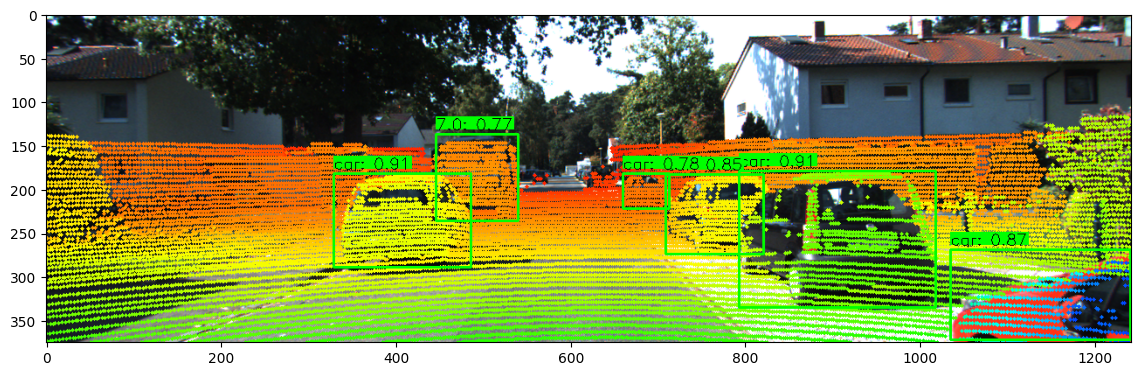

False

In [150]:
lidar_img_with_bboxes= draw_boxes_cv(img_3, pred_bboxes)
fig_fusion = plt.figure(figsize=(14, 7))
ax_fusion = fig_fusion.subplots()
ax_fusion.imshow(lidar_img_with_bboxes)
plt.show()
cv2.imwrite("output/lidar_bboxes.png", lidar_img_with_bboxes)

**In this course, we'll see a few ways to filter outliers.** <p>
Outliers are the points that belong to the bounding box, but not to the object.<p>
Here's an example of outliers:<p>
![outlier image](https://i.ibb.co/Fg0KV3k/Screenshot-2021-05-31-at-22-31-29.png)

In this image, the points belong to the truck, but are also counted as part of the car.

The first technique we can use for that is a shrink factor.
Instead of considering the whole bounding box, we're considering only a part of it. **A common choice is 10-15% shrinking.**
![image_shrinks](https://i.ibb.co/Zcgzz6F/Screenshot-2021-05-31-at-22-45-36.png)

--- TODO --- Code a function that return the points inside a bounding box according to a shrink factor

In [151]:
def rectContains(rect, pt,w, h, shrink_factor=0):
    # Calculate the new corners of the rectangle after applying the shrink factor
    x1 = rect[0] + (rect[2] - rect[0]) * shrink_factor
    y1 = rect[1] + (rect[3] - rect[1]) * shrink_factor
    x2 = rect[2] - (rect[2] - rect[0]) * shrink_factor
    y2 = rect[3] - (rect[3] - rect[1]) * shrink_factor

    # Check if the point is within the shrunk rectangle
    return x1 < pt[0] < x2 and y1 < pt[1] < y2


**The second way will be through Outlier removal techniques. <p>**
We can cite a few: 3 Sigma, RANSAC, and others...

--- TODO--- Code a function to remove the outliers according to One Sigma

In [152]:
import statistics
import random

def filter_outliers(distances):
    inliers = []
    mu  = statistics.mean(distances)
    std = statistics.stdev(distances)
    for x in distances:
        if abs(x-mu) < std:
            # This is an INLIER
            inliers.append(x)
    return inliers

def get_best_distance(distances, technique="closest"):
    if technique == "closest":
        return min(distances)
    elif technique =="average":
        return statistics.mean(distances)
    elif technique == "random":
        return random.choice(distances)
    else:
        return statistics.median(sorted(distances))

-- TODO-- Code a function that implements the fusion between boxes and points

In [165]:
def lidar_camera_fusion(self, pred_bboxes, image):
    img_bis = image.copy()

    cmap = plt.cm.get_cmap("hsv", 256)
    cmap = np.array([cmap(i) for i in range(256)])[:, :3] * 255
    distances = []
    for box in pred_bboxes:
        distances = []
        for i in range(self.imgfov_pts_2d.shape[0]):
            #depth = self.imgfov_pc_rect[i, 2]
            depth = self.imgfov_pc_velo[i,0]
            if (rectContains(box, self.imgfov_pts_2d[i], image.shape[1], image.shape[0], shrink_factor=0.1)==True):
                distances.append(depth)

                color = cmap[int(510.0 / depth), :]
                cv2.circle(img_bis,(int(np.round(self.imgfov_pts_2d[i, 0])), int(np.round(self.imgfov_pts_2d[i, 1]))),2,color=tuple(color),thickness=-1,)
        h, w, _ = img_bis.shape
        if len(distances) >2:
            distances = filter_outliers(distances)
            best_distance = get_best_distance(distances, technique="average")
            cv2.putText(img_bis, f"{round(best_distance,2)}", (int(box[0]+((box[2]-box[0])/2)),(int(box[1]+((box[3]-box[1])/2)))), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255, 0, 0), 3, cv2.LINE_AA)    
        distances_to_keep = []
    
    return img_bis, distances

LiDAR2Camera.lidar_camera_fusion = lidar_camera_fusion

C:\Users\kagad\AppData\Local\Temp\ipykernel_21572\224779203.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("hsv", 256)


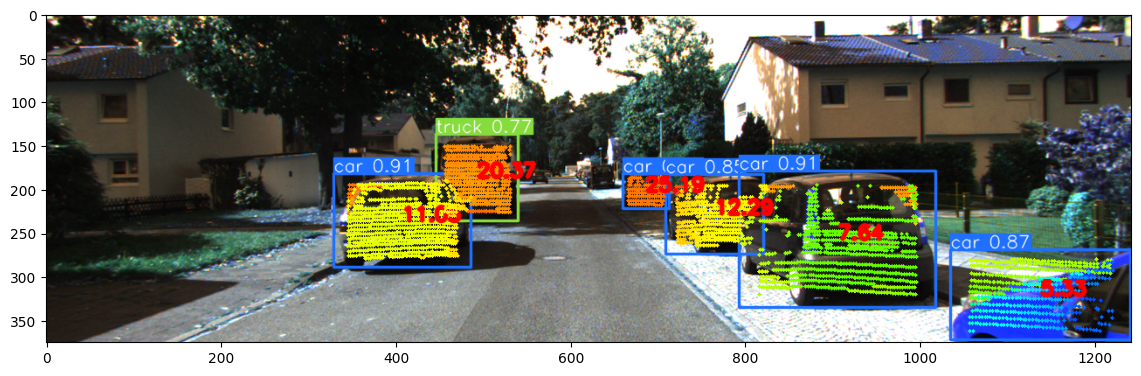

In [166]:
final_result, _ = lidar2cam.lidar_camera_fusion(pred_bboxes, result)

fig_keeping = plt.figure(figsize=(14, 7))
ax_keeping = fig_keeping.subplots()
ax_keeping.imshow(final_result)
plt.show()

### Build a Pipeline

In [167]:
def pipeline (self, image, point_cloud):
    "For a pair of 2 Calibrated Images"
    img = image.copy()
    # Show LidAR on Image
    lidar_img = self.show_lidar_on_image(point_cloud[:,:3], image)
    # Run obstacle detection in 2D
    result, pred_bboxes = run_obstacle_detection(img)
    # Fuse Point Clouds & Bounding Boxes
    img_final, _ = self.lidar_camera_fusion(pred_bboxes, result)
    return img_final

LiDAR2Camera.pipeline = pipeline

C:\Users\kagad\AppData\Local\Temp\ipykernel_21572\420554473.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("hsv", 256)


0: 224x640 5 cars, 1 truck, 62.7ms
Speed: 3.1ms preprocess, 62.7ms inference, 9.6ms postprocess per image at shape (1, 3, 224, 640)


C:\Users\kagad\AppData\Local\Temp\ipykernel_21572\224779203.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("hsv", 256)


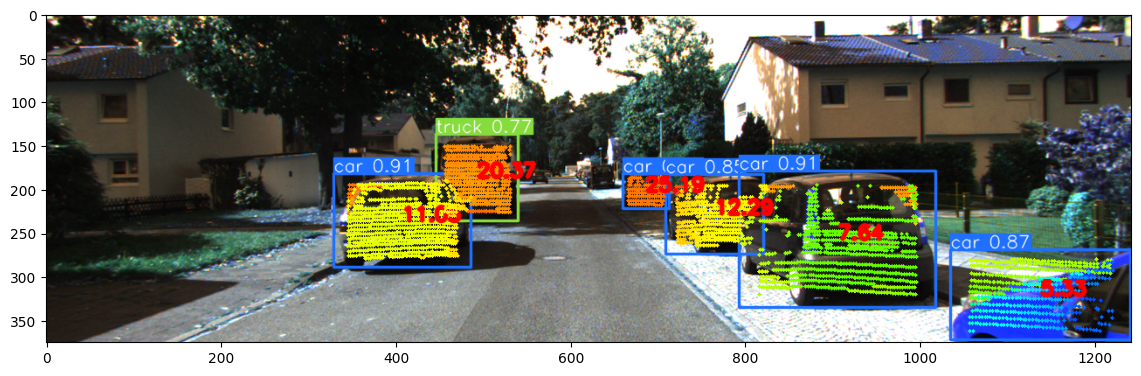

In [168]:
image_files = sorted(glob.glob("data/img/*.png"))
point_files = sorted(glob.glob("data/velodyne/*.pcd"))
label_files = sorted(glob.glob("data/label/*.txt"))
calib_files = sorted(glob.glob("data/calib/*.txt"))

lidar2cam = LiDAR2Camera(calib_files[index])
cloud = o3d.io.read_point_cloud(pcd_file)
points= np.asarray(cloud.points)

index = 0
image = cv2.cvtColor(cv2.imread(image_files[index]), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(14,7))
final_result = lidar2cam.pipeline(image.copy(), points)
plt.imshow(final_result)
plt.show()

## Comparing with the Ground Truth


Text(0.5, 1.0, 'Prediction')

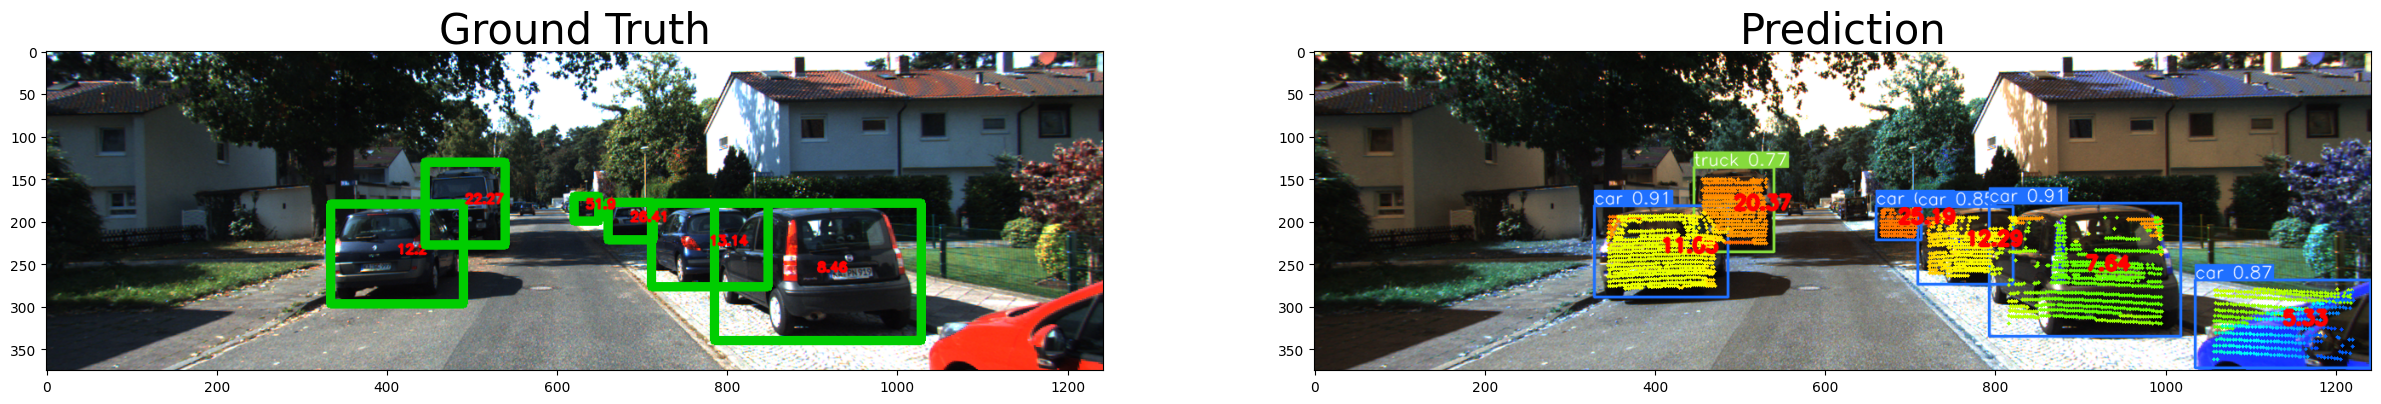

In [169]:
image_gt = image.copy()

with open(label_files[index], 'r') as f:
    fin = f.readlines()
    for line in fin:
        if line.split(" ")[0] != "DontCare":
            #print(line)
            x1_value = int(float(line.split(" ")[4]))
            y1_value = int(float(line.split(" ")[5]))
            x2_value = int(float(line.split(" ")[6]))
            y2_value = int(float(line.split(" ")[7]))
            dist = float(line.split(" ")[13])
            cv2.rectangle(image_gt, (x1_value, y1_value), (x2_value, y2_value), (0,205,0), 10)
            cv2.putText(image_gt, str(dist), (int((x1_value+x2_value)/2),int((y1_value+y2_value)/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2, cv2.LINE_AA)    

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,20))
ax1.imshow(image_gt)
ax1.set_title('Ground Truth', fontsize=30)
ax2.imshow(final_result) # or flag
ax2.set_title('Prediction', fontsize=30)

## Inferece the video

In [170]:
video_images = sorted(glob.glob("video_4/images/*.png"))
video_points = sorted(glob.glob("video_4/points/*.pcd"))

# Build a LiDAR2Cam object
lidar2cam_video = LiDAR2Camera(calib_files[0])

result_video = []

for idx, img in enumerate(video_images):
    image = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
    point_cloud = np.asarray(o3d.io.read_point_cloud(video_points[idx]).points)
    result_video.append(lidar2cam_video.pipeline(image, point_cloud))

out = cv2.VideoWriter('output/test.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, (image.shape[1],image.shape[0]))
 
for i in range(len(result_video)):
    out.write(cv2.cvtColor(result_video[i], cv2.COLOR_BGR2RGB))
    #out.write(result_video[i])
out.release()

C:\Users\kagad\AppData\Local\Temp\ipykernel_21572\420554473.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("hsv", 256)


0: 224x640 2 cars, 62.7ms
Speed: 3.5ms preprocess, 62.7ms inference, 3.0ms postprocess per image at shape (1, 3, 224, 640)


C:\Users\kagad\AppData\Local\Temp\ipykernel_21572\224779203.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("hsv", 256)



0: 224x640 2 cars, 61.6ms
Speed: 3.0ms preprocess, 61.6ms inference, 3.1ms postprocess per image at shape (1, 3, 224, 640)

0: 224x640 4 cars, 69.1ms
Speed: 0.0ms preprocess, 69.1ms inference, 3.9ms postprocess per image at shape (1, 3, 224, 640)

0: 224x640 3 cars, 62.5ms
Speed: 9.6ms preprocess, 62.5ms inference, 3.4ms postprocess per image at shape (1, 3, 224, 640)

0: 224x640 3 cars, 61.2ms
Speed: 3.5ms preprocess, 61.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 640)

0: 224x640 1 car, 66.8ms
Speed: 0.0ms preprocess, 66.8ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)

0: 224x640 2 cars, 59.3ms
Speed: 3.9ms preprocess, 59.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 640)

0: 224x640 2 cars, 63.1ms
Speed: 0.0ms preprocess, 63.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 640)

0: 224x640 2 cars, 57.2ms
Speed: 0.0ms preprocess, 57.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 640)

0: 224x6